# Lab4 CPA

本实验用于演示：
1. 显示曲线文件。
2. CPA分析破解密钥。

## 准备工作

软件：
1. 安装最新[`CrackNuts`](https://cracknuts.cn/docs/doc/getting-started/host_sdk_installation)控制分析软件。
2. 安装[SCARR](https://cracknuts.cn/blog/2025/04/02/install-scarr)侧信道分析包。

数据：
波形曲线文件'../traces/sw_aes_200.zarr'。

## 实验步骤

1. 展示波形文件
2. CPA分析破解密钥

### 导入分析包

In [2]:
from scarr.engines.cpa import CPA as cpa
from scarr.file_handling.trace_handler import TraceHandler as th
from scarr.model_values.sbox_weight import SboxWeight
from scarr.container.container import Container, ContainerOptions
import numpy as np
from smartcard.util import toHexString, toBytes

import cracknuts as cn  # 导入cracknuts包

In [ ]:
dataset_name = '../traces/sw_aes_200.zarr' # 曲线文件路径
handler2 = th(fileName=dataset_name) 

opened zarr file  ../traces/sw_aes_200.zarr


In [4]:
# 显示曲线分析面板
tap = cn.panel_trace()
# 引入波形文件数据集对象
from cracknuts.trace.trace import ScarrTraceDataset
# 加载波形文件
scarr_trace_dataset = ScarrTraceDataset.load(dataset_name)
# 将数据集配置到波形显示面板
tap.set_trace_dataset(scarr_trace_dataset)
tap

TracePanelWidget(chart_size={'width': 0, 'height': 0}, language='zh', overview_select_range=(0, 0), overview_t…

In [ ]:
# 显示前十条曲线
tap.show_trace[0, :10] 

In [7]:
# 选择分析模型
model = SboxWeight() 
engine2 = cpa(model)

In [ ]:
# CPA分析
container2 = Container(options=ContainerOptions(engine=engine2, handler=handler2), trace_index=list(range(200)),model_positions = [x for x in range(16)]) 
container2.run()

In [ ]:
# 展示密钥分析结果
results2 = container2.engine.get_result()
results = np.squeeze(engine2.get_candidate())
toHexString(list(results))

'11 22 33 44 55 66 77 88 99 00 AA BB CC DD EE FF'

In [ ]:
# 展示结果排序
result = np.squeeze(results2)
result = result[0]

candidate = [None for _ in range(result.shape[0])]

for i in range(result.shape[0]):
    candidate[i] = np.unravel_index(np.abs(result[i, :]).argmax(), result[i, :].shape[0:])[0]

In [12]:
candidates = np.empty(256, dtype=np.float64)
for k in range(256):
    candidates[k] = result[k,candidate[k]]
ck = np.abs(candidates).argmax()

In [13]:
for _i in range(0, 10):
    print('第',str(_i+1),'个候选值：',hex(np.abs(candidates).argsort()[::-1][_i]),'， 对应的相关系数为：',str(candidates[np.abs(candidates).argsort()[::-1][_i]]))

第 1 个候选值： 0x11 ， 对应的相关系数为： 0.6789133548736572
第 2 个候选值： 0xe1 ， 对应的相关系数为： 0.36615246534347534
第 3 个候选值： 0x58 ， 对应的相关系数为： -0.34870395064353943
第 4 个候选值： 0xe6 ， 对应的相关系数为： -0.3310008943080902
第 5 个候选值： 0x63 ， 对应的相关系数为： -0.3274860084056854
第 6 个候选值： 0x98 ， 对应的相关系数为： 0.30935850739479065
第 7 个候选值： 0x16 ， 对应的相关系数为： -0.30923327803611755
第 8 个候选值： 0x8e ， 对应的相关系数为： -0.30905696749687195
第 9 个候选值： 0xd1 ， 对应的相关系数为： -0.3069278597831726
第 10 个候选值： 0x22 ， 对应的相关系数为： 0.3026044964790344


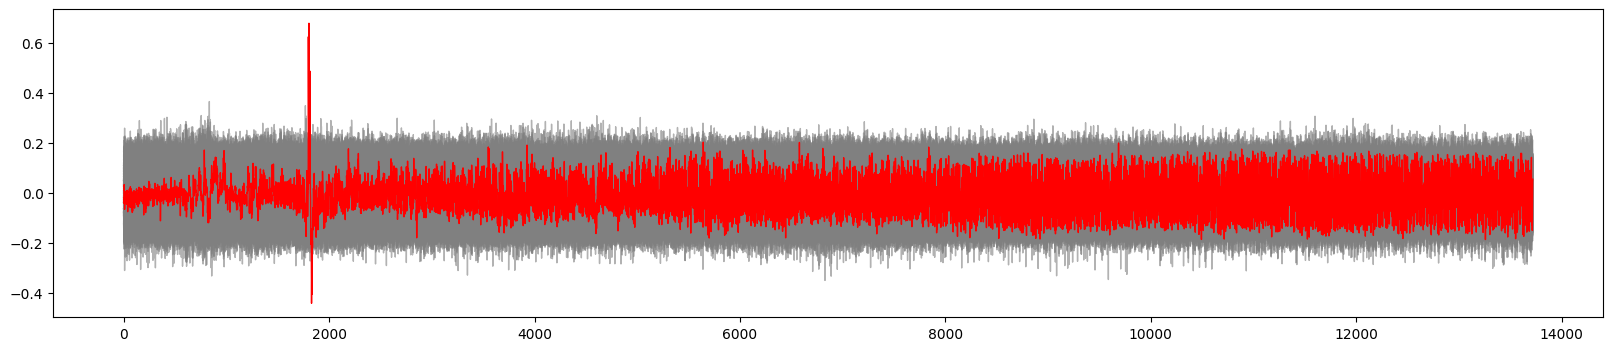

In [ ]:
# 展示第1个字节密钥相关性
import numpy as np
import matplotlib.pyplot as plt

d = results2[0,0,0]

x = np.arange(d.shape[1])

plt.figure(figsize=(20, 4))

hightlight_index = 0x11

for i, y in enumerate(d):
    if i == hightlight_index:
        continue
    else:
        plt.plot(x, y, color='gray', alpha=0.6, linewidth=1)

plt.plot(x, d[hightlight_index], color='red', linewidth=1)

plt.show()

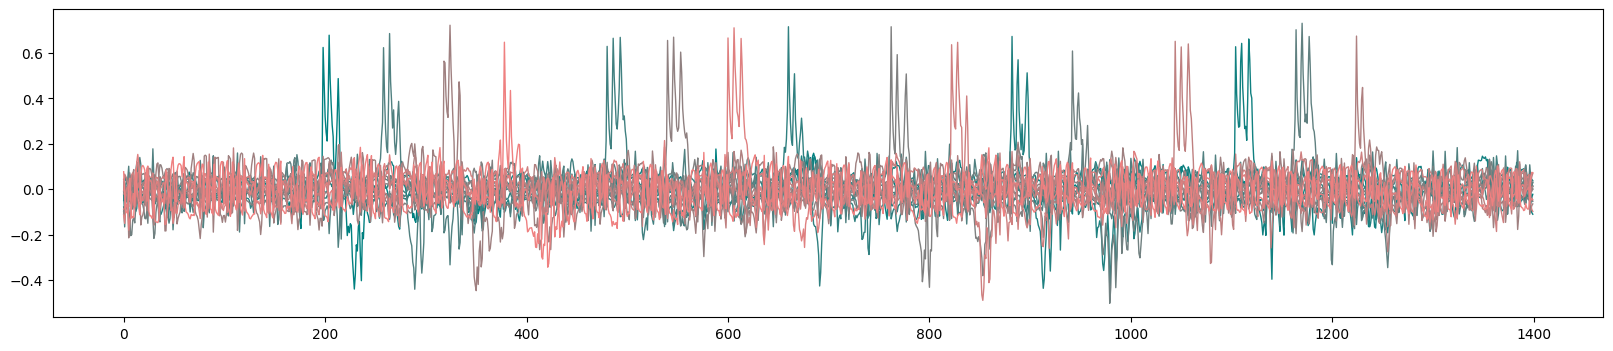

In [21]:
# 展示16个密钥泄露位置
import numpy as np
import matplotlib.pyplot as plt

hightlight_index = [0x11, 0x22, 0x33, 0x44, 0x55, 0x66, 0x77, 0x88, 0x99, 0x00, 0xAA, 0xBB, 0xCC, 0xDD, 0xEE, 0xFF]
plt.figure(figsize=(20, 4))

cmap = plt.cm.inferno  
for index in range(len(hightlight_index)):
    d = results2[0,index,0,:,1600:3000]
    x = np.arange(d.shape[1])
    # color = cmap(index/32)
    color = (index/16, 0.5, 0.5) 
    # plt.plot(x, d[hightlight_index[index]], cmap='viridis', linewidth=1)
    plt.plot(x, d[hightlight_index[index]], color=color, linewidth=1)

plt.show()